In [1]:
#importing all the libraries

import sys , os , re , csv , codecs , numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense,Input,LSTM,Embedding,Dropout,Activation
from keras.layers import Bidirectional,GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints , optimizers, layers
from keras.utils import to_categorical


Using TensorFlow backend.
E:\anaconda_installation_files\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
E:\anaconda_installation_files\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
E:\anaconda_installation_files\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
E:\anaconda_installation_files\lib\site-packages\tensorflow\py

In [2]:
#getting the train data
train = pd.read_csv('train.csv')
#loading the test data
test = pd.read_csv('test.csv')
#diplay first 5 rows of train
train.head()
#one hot encoding the labels
df = pd.concat([train,pd.get_dummies(train['sentiment'])],axis=1)
#df.head()
train_data = df['tweet_text']
#train_data.head()

In [3]:
#df_test = pd.concat([test,pd.get_dummies(test['sentiment'])],axis=1)
#classes2 = ['neutral' , 'negative' , 'positive']
#y_val = df_test[classes2].values
#y_val

In [4]:
test_data = test['tweet_text']
test_data.head()

0    @jjuueellzz down in the Atlantic city, ventnor...
1    Musical awareness: Great Big Beautiful Tomorro...
2    On Radio786 100.4fm 7:10 Fri Oct 19 Labour ana...
3    Kapan sih lo ngebuktiin,jan ngomong doang Susa...
4    Excuse the connectivity of this live stream, f...
Name: tweet_text, dtype: object

In [5]:
#creating the array of labels in serial with their respective texts
classes = ['neutral' , 'negative' , 'positive']
y = df[classes].values
y

array([[0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0]], dtype=uint8)

In [6]:
#checking for null values in train and test data
train.isnull().any()
test.isnull().any()

tweet_id      False
tweet_text    False
dtype: bool

In [7]:
#configuration  parameters
LATENT_DIM_DECODER = 400
BATCH_SIZE =32
EPOCHS = 10
LATENT_DIM = 400
NUM_SAMPLES = 10000
MAX_SEQUENCE_LEN = 1000
MAX_NUM_WORDS = 40000
EMBEDDING_DIM = 100



In [8]:
#NLTK python library for preprocessing
import nltk
#nltk.download('wordnet')
#for tokenization
from nltk.tokenize import RegexpTokenizer
#for stemming
from nltk.stem import WordNetLemmatizer,PorterStemmer
#for removing stopwords
from nltk.corpus import stopwords
#importing regex library of python
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 
#function for performing all preproccing steps at once
def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens]#  if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)

#make a dataframe of preprocessed text
df['cleanText']=train_data.map(lambda s:preprocess(s)) 

In [9]:
test['clean_text']=test['tweet_text'].map(lambda s:preprocess(s))
test_final = test['clean_text']
test_final

0       jjuueellzz down in the atlantic city ventnor m...
1       musical awareness great big beautiful tomorrow...
2       on radio fm fri oct labour analyst shawn hatti...
3       kapan sih lo ngebuktiin jan ngomong doang susa...
4       excuse the connectivity of this live stream fr...
                              ...                        
5393    it s a wednesday girls night out as s band wil...
5394    night college course sorted just have to enrol...
5395    for the st time in years for your splendiferou...
5396    nurses day may nursing the heart beat of the h...
5397    we have minutes left until the nd episode of s...
Name: clean_text, Length: 5398, dtype: object

In [10]:
#breaking the sentence into unique words/tokens
#expecting max tokens to be 20k
train_final = df['cleanText']
max_feat=40000
#tokenize sentence into list of words
tokenizer = Tokenizer(num_words=max_feat)#setting up tokenizer
#fiiting the tokenizer on out data
tokenizer.fit_on_texts(list(train_final))


In [11]:
train_final

0        gas by my house hit i um going to chapel hill ...
1        theo walcott is still shit uc watch rafa and j...
2        its not that i um a gsp fan uc i just hate nic...
3        iranian general says israel us iron dome can u...
4        tehran uc mon amour obama tried to establish t...
                               ...                        
21460    the day after newark ill be able to say i met ...
21461    fec hold farewell session for seven ministers ...
21462    luca di montezemolo who s last day was monday ...
21463    coffee is pretty much the answer to all questi...
21464    niki lauda just confirmed to sky that alonso w...
Name: cleanText, Length: 21465, dtype: object

In [12]:
tokenizer2 = Tokenizer(num_words=max_feat)#setting up tokenizer
#fiiting the tokenizer on out data
tokenizer2.fit_on_texts(list(test_final))

In [13]:
#converting text into sequence of numbers to feed in neural network
sequence_train = tokenizer.texts_to_sequences(train_final)
sequence_test = tokenizer2.texts_to_sequences(test_final)
# get the word to index mapping for input language
word2idx_inputs = tokenizer.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))


Found 34302 unique input tokens.


In [14]:
#LOADING PRETRAINED WORD VECTORS
# store all the pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open('glove.6B.100d.txt', encoding="utf8") as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))


Loading word vectors...
Found 400000 word vectors.


In [15]:
#EMBEDDING MATRIX
# prepare embedding matrix of words for embedding layer
print('Filling pre-trained embeddings...')
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
  if i < MAX_NUM_WORDS:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [16]:
max_len = [len(s) for s in sequence_train]
print(max(max_len))

1074


In [17]:
#scaling all the sequences to a fixed length
#dimension of input to the layer should be constant
#scaling each comment sequence to a fixed length to 200
#comments smaller than 200 will be padded with zeros to make their length as 200
max_len=1000
#pad the train and text sequence to be of fixed length (in keras input in lstm should be of fixed length sequnece)
x_train=pad_sequences(sequence_train,maxlen=max_len)
x_test=pad_sequences(sequence_test,maxlen=max_len)

In [18]:
# create embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=max_len,
  trainable=False
)

Checking if we used right length of sequence padding 
for greater length of comments we have to take such length sequence padding that on deleting some information doesnt result in loss of important imformation

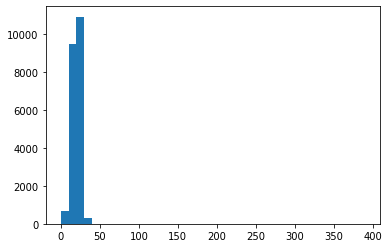

In [19]:
len_words = [len(words) for words in sequence_train]
#distribution of sequence
plt.hist(len_words, bins = np.arange(0,400,10))
plt.show()
# we can see that most of the comments have [0,50]  words

Now the training data is ready to be fed into the input layer as input

In [20]:
input = Input(shape=(max_len,))

In [21]:
#feeding the output of previous layer to the embedding layer that converts 
#the sequences into vector representation to detect relevance and context 
#of a particular word
embed_layer =embedding_layer(input)

In [22]:
#passing the previous output as input to the BI_LSTM layer
LSTM_layer = Bidirectional(LSTM(128, return_sequences=True, name='BI_lstm_layer'))(embed_layer)

In [23]:
#dimension reduction using pooling layer
red_dim_layer = GlobalMaxPool1D()(LSTM_layer)

In [24]:
##### adding dropout layer for better generalization
#setting value as 0.1 , which means 10$ of nodes will be randomly disabled
drop_layer = Dropout(0.5)(red_dim_layer)

In [25]:
#densely connected layer
dense1 = Dense(128,activation='relu')(drop_layer)

In [26]:
#adding another dropout layer
drop_layer2 = Dropout(0.5)(dense1)

In [27]:
#adding the output dense layer with sigmoid activation to get result 
#3  classes as output
output_dense = Dense(3,activation='softmax')(drop_layer2)

In [28]:
#connecting the inputs and outputs to create a model and compiling the model
from keras.optimizers import Adagrad,Adam
model = Model(inputs=input , outputs = output_dense)
model.compile(loss = 'categorical_crossentropy',
             optimizer = Adam(lr=0.001),
             metrics = ['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         3430300   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1000, 256)         234496    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0   

In [29]:
#Fitting the model 
batch_size=32
epochs = 20
model.fit(x_train,y,batch_size=batch_size,epochs = epochs,validation_split=0.2)


Train on 17172 samples, validate on 4293 samples
Epoch 1/20
17172/17172 [==============================] - 1022s 60ms/step - loss: 0.9472 - accuracy: 0.5217 - val_loss: 0.8524 - val_accuracy: 0.5779
Epoch 2/20
17172/17172 [==============================] - 1013s 59ms/step - loss: 0.8311 - accuracy: 0.6120 - val_loss: 0.8503 - val_accuracy: 0.5889
Epoch 3/20
17172/17172 [==============================] - 1034s 60ms/step - loss: 0.7863 - accuracy: 0.6396 - val_loss: 0.8282 - val_accuracy: 0.5968
Epoch 4/20
17172/17172 [==============================] - 1074s 63ms/step - loss: 0.7608 - accuracy: 0.6540 - val_loss: 0.8286 - val_accuracy: 0.6061
Epoch 5/20
17172/17172 [==============================] - 1048s 61ms/step - loss: 0.7333 - accuracy: 0.6654 - val_loss: 0.8468 - val_accuracy: 0.5996
Epoch 6/20
17172/17172 [==============================] - 1078s 63ms/step - loss: 0.7069 - accuracy: 0.6824 - val_loss: 0.8261 - val_accuracy: 0.6108
Epoch 7/20
17172/17172 [==========================

In [31]:
model.save('sentiment2iit2_glove_classification.h5')